# ASVspoof5 Train-Only Probe (Tuned) ? Bonafide vs Each Spoof System (A01-A08), B -> C

For each target system `A01..A08`:
- task = `bonafide (0)` vs `target_system spoof (1)`
- tune on a speaker-disjoint `B_train/B_val` split
- retrain on full `B` using chosen hyperparameters
- evaluate on `C`


In [1]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")
MANIFEST_PATH = PROJECT_ROOT / "redimnet" / "tcav" / "deepfakes" / "asvspoof5" / "asvspoof5_train_only_selected_utterances_plan.csv"
SUBSET_AUDIO_ROOT = PROJECT_ROOT / "data" / "datasets" / "asvspoof5_train_only_subset_audio"
EMBED_CACHE_DIR = PROJECT_ROOT / "data" / "embeddings" / "asvspoof5_train_only_abc"
EMBED_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Tuning config (speaker-disjoint split inside group B)
VAL_SPEAKER_COUNT = 3      # from 15 B speakers -> 12 train, 3 val
TUNE_SEED = 42
C_GRID = [0.01, 0.1, 1.0, 10.0]
CLASS_WEIGHT_OPTIONS = [None, 'balanced']
THRESH_GRID = np.linspace(0.05, 0.95, 181)
FORCE_RECOMPUTE_EMBEDDINGS = False

print("DEVICE:", DEVICE)
print("MANIFEST_PATH:", MANIFEST_PATH)
print("SUBSET_AUDIO_ROOT:", SUBSET_AUDIO_ROOT)

SYSTEM_IDS = [f'A{i:02d}' for i in range(1, 9)]
OUT_DIR = PROJECT_ROOT / 'data' / 'models' / 'asvspoof5_train_only_probe_BC_all_systems_vs_bonafide_tuned'
OUT_DIR.mkdir(parents=True, exist_ok=True)


DEVICE: cuda
MANIFEST_PATH: /home/SpeakerRec/BioVoice/redimnet/tcav/deepfakes/asvspoof5/asvspoof5_train_only_selected_utterances_plan.csv
SUBSET_AUDIO_ROOT: /home/SpeakerRec/BioVoice/data/datasets/asvspoof5_train_only_subset_audio


In [3]:
LABEL_MAP = {"bonafide": 0, "spoof": 1}


def build_audio_path(row, subset_root: Path) -> Path:
    return subset_root / str(row["group"]) / str(row["label"]) / f"{row['utt_id']}.flac"


def load_manifest(manifest_path: Path, subset_root: Path) -> pd.DataFrame:
    df = pd.read_csv(manifest_path).copy()
    req = {"group","speaker_id","utt_id","label","system_id"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Manifest missing columns: {sorted(missing)}")
    df["label_str"] = df["label"].astype(str)
    df["label_id"] = df["label_str"].map(LABEL_MAP).astype(int)
    df["audio_path"] = df.apply(lambda r: str(build_audio_path(r, subset_root)), axis=1)
    df["audio_exists"] = df["audio_path"].map(lambda p: Path(p).exists())
    return df


def embed_with_redim(model, wav_path: str, device: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]
    wav = wav.to(device)
    with torch.no_grad():
        emb = model(wav)
    return emb.squeeze(0).detach().cpu().numpy().astype(np.float32)


def extract_embeddings_for_df(df_paths: pd.DataFrame, model, device: str, cache_npz: Path, force_recompute: bool=False):
    if cache_npz.exists() and not force_recompute:
        payload = np.load(cache_npz, allow_pickle=True)
        X = payload['X']
        utt_ids = payload['utt_ids'].astype(str)
        lut = pd.DataFrame({'utt_id': utt_ids, '_idx': np.arange(len(utt_ids))})
        m = df_paths[['utt_id']].merge(lut, on='utt_id', how='left', validate='one_to_one')
        if m['_idx'].isna().any():
            miss = m.loc[m['_idx'].isna(), 'utt_id'].tolist()[:10]
            raise RuntimeError(f"Embedding cache missing utt_ids, examples: {miss}")
        return X[m['_idx'].astype(int).to_numpy()]

    vecs, ids = [], []
    for rec in tqdm(df_paths.to_dict('records'), desc=f"Embedding {len(df_paths)}"):
        p = Path(rec['audio_path'])
        if not p.exists():
            raise FileNotFoundError(f"Missing audio: {p}")
        vecs.append(embed_with_redim(model, str(p), device))
        ids.append(str(rec['utt_id']))
    X = np.stack(vecs).astype(np.float32)
    np.savez_compressed(cache_npz, X=X, utt_ids=np.array(ids, dtype=object))
    return X


def split_B_speakers(df: pd.DataFrame, n_val_speakers=3, seed=42):
    b_speakers = sorted(df.loc[df['group'].eq('B'), 'speaker_id'].astype(str).unique().tolist())
    if len(b_speakers) <= n_val_speakers:
        raise ValueError(f"Not enough B speakers ({len(b_speakers)}) for val={n_val_speakers}")
    rng = np.random.default_rng(seed)
    shuffled = b_speakers.copy()
    rng.shuffle(shuffled)
    val = sorted(shuffled[:n_val_speakers])
    train = sorted(shuffled[n_val_speakers:])
    return train, val


def metrics_at_threshold(y_true, p1, thr):
    y_hat = (p1 >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat).tolist()
    out = {
        'threshold': float(thr),
        'accuracy': float(accuracy_score(y_true, y_hat)),
        'auc': float(roc_auc_score(y_true, p1)) if len(np.unique(y_true)) == 2 else None,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_true, y_hat, output_dict=True, zero_division=0),
    }
    # balanced accuracy (manual to avoid extra import)
    tn, fp = cm[0]
    fn, tp = cm[1]
    tnr = tn / (tn + fp) if (tn + fp) else 0.0
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    out['balanced_accuracy'] = float((tnr + tpr) / 2.0)
    out['bonafide_recall'] = float(tnr)
    out['spoof_recall'] = float(tpr)
    return out, y_hat


def tune_logreg_with_speaker_val(X, y, df_meta, c_grid, class_weight_options, thresh_grid, val_speaker_count=3, seed=42):
    b_train_speakers, b_val_speakers = split_B_speakers(df_meta, n_val_speakers=val_speaker_count, seed=seed)
    is_b_train = df_meta['group'].eq('B') & df_meta['speaker_id'].astype(str).isin(b_train_speakers)
    is_b_val = df_meta['group'].eq('B') & df_meta['speaker_id'].astype(str).isin(b_val_speakers)
    is_c_test = df_meta['group'].eq('C')

    X_btr, y_btr = X[is_b_train.to_numpy()], y[is_b_train.to_numpy()]
    X_bval, y_bval = X[is_b_val.to_numpy()], y[is_b_val.to_numpy()]
    X_B, y_B = X[df_meta['group'].eq('B').to_numpy()], y[df_meta['group'].eq('B').to_numpy()]
    X_C, y_C = X[is_c_test.to_numpy()], y[is_c_test.to_numpy()]

    best = None
    tuning_rows = []
    for cw in class_weight_options:
        for cval in c_grid:
            scaler = StandardScaler()
            X_btr_s = scaler.fit_transform(X_btr)
            X_bval_s = scaler.transform(X_bval)
            clf = LogisticRegression(max_iter=2000, C=float(cval), class_weight=cw, random_state=42)
            clf.fit(X_btr_s, y_btr)
            p_bval = clf.predict_proba(X_bval_s)[:, 1]
            for thr in thresh_grid:
                m_val, _ = metrics_at_threshold(y_bval, p_bval, float(thr))
                row = {
                    'C': float(cval),
                    'class_weight': str(cw),
                    'threshold': float(thr),
                    'val_balanced_accuracy': m_val['balanced_accuracy'],
                    'val_accuracy': m_val['accuracy'],
                    'val_auc': m_val['auc'],
                    'val_bonafide_recall': m_val['bonafide_recall'],
                    'val_spoof_recall': m_val['spoof_recall'],
                }
                tuning_rows.append(row)
                key = (m_val['balanced_accuracy'], m_val['accuracy'], m_val['auc'] if m_val['auc'] is not None else -1.0)
                if best is None or key > best['_key']:
                    best = {'_key': key, **row}

    # retrain final model on full B using selected hyperparameters
    final_scaler = StandardScaler()
    X_B_s = final_scaler.fit_transform(X_B)
    X_C_s = final_scaler.transform(X_C)
    final_clf = LogisticRegression(
        max_iter=2000,
        C=float(best['C']),
        class_weight=(None if best['class_weight'] == 'None' else 'balanced'),
        random_state=42,
    )
    final_clf.fit(X_B_s, y_B)
    p_B = final_clf.predict_proba(X_B_s)[:, 1]
    p_C = final_clf.predict_proba(X_C_s)[:, 1]

    chosen_thr = float(best['threshold'])
    m_B, yhat_B = metrics_at_threshold(y_B, p_B, chosen_thr)
    m_C, yhat_C = metrics_at_threshold(y_C, p_C, chosen_thr)

    # default threshold reference (0.5) on test C for comparison
    m_C_default, yhat_C_default = metrics_at_threshold(y_C, p_C, 0.5)

    result = {
        'b_train_speakers': b_train_speakers,
        'b_val_speakers': b_val_speakers,
        'best_params': {k: best[k] for k in ['C','class_weight','threshold','val_balanced_accuracy','val_accuracy','val_auc','val_bonafide_recall','val_spoof_recall']},
        'metrics_B_tuned_threshold': m_B,
        'metrics_C_tuned_threshold': m_C,
        'metrics_C_default_threshold_0_5': m_C_default,
    }

    masks = {
        'is_B': df_meta['group'].eq('B').to_numpy(),
        'is_C': df_meta['group'].eq('C').to_numpy(),
    }
    tuning_df = pd.DataFrame(tuning_rows).sort_values(['val_balanced_accuracy','val_accuracy','val_auc'], ascending=False)
    return final_scaler, final_clf, chosen_thr, p_B, p_C, yhat_B, yhat_C, yhat_C_default, result, tuning_df, masks


def plot_confmat(cm, title):
    cm = np.array(cm)
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['bonafide','spoof'], rotation=30, ha='right')
    ax.set_yticklabels(['bonafide','spoof'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(title)
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(int(v)), ha='center', va='center')
    plt.colorbar(im, ax=ax, fraction=0.046)
    plt.tight_layout()
    return fig


In [4]:
redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)
print("Loaded ReDimNet on", DEVICE)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet on cuda


In [5]:
manifest_df = load_manifest(MANIFEST_PATH, SUBSET_AUDIO_ROOT)
bc_df = manifest_df[manifest_df['group'].isin(['B','C'])].copy().reset_index(drop=True)
print('B/C rows:', len(bc_df))
print('Missing audio:', int((~bc_df['audio_exists']).sum()))
print('Systems in spoof rows:', sorted(bc_df.loc[bc_df['label_str']=='spoof','system_id'].unique().tolist()))


B/C rows: 1280
Missing audio: 0
Systems in spoof rows: ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08']


In [6]:
summary_rows = []
all_pred_parts = []

for target_system in SYSTEM_IDS:
    print(f'\n=== {target_system} vs bonafide ===')
    task_df = bc_df[(bc_df['label_str'].eq('bonafide')) | ((bc_df['label_str'].eq('spoof')) & (bc_df['system_id'].eq(target_system)))].copy().reset_index(drop=True)
    task_df['task_label_id'] = np.where(task_df['label_str'].eq('bonafide'), 0, 1).astype(int)
    print(task_df.groupby(['group','label_str','system_id']).size())

    cache_npz = EMBED_CACHE_DIR / f'embeddings_BC_{target_system}_vs_bonafide.npz'
    X_task = extract_embeddings_for_df(task_df[['utt_id','audio_path']], redim_model, DEVICE, cache_npz, force_recompute=FORCE_RECOMPUTE_EMBEDDINGS)
    y_task = task_df['task_label_id'].to_numpy().astype(int)

    scaler, clf, thr, p_B, p_C, yhat_B, yhat_C, yhat_C_default, results, tuning_df, masks = tune_logreg_with_speaker_val(
        X_task, y_task, task_df.rename(columns={'task_label_id':'label_id'}), C_GRID, CLASS_WEIGHT_OPTIONS, THRESH_GRID,
        val_speaker_count=VAL_SPEAKER_COUNT, seed=TUNE_SEED
    )

    sys_dir = OUT_DIR / target_system
    sys_dir.mkdir(parents=True, exist_ok=True)
    with open(sys_dir / 'scaler.pkl', 'wb') as f: pickle.dump(scaler, f)
    with open(sys_dir / 'logistic_regression.pkl', 'wb') as f: pickle.dump(clf, f)
    (sys_dir / 'run_summary.json').write_text(json.dumps(results, indent=2), encoding='utf-8')
    (sys_dir / 'tuning_results_top200.csv').write_text(tuning_df.head(200).to_csv(index=False), encoding='utf-8')

    pred_B = task_df.loc[masks['is_B'], ['group','speaker_id','utt_id','label_str','system_id']].copy().reset_index(drop=True)
    pred_B['split'] = 'train_B'; pred_B['task_label_id'] = 0
    pred_B.loc[pred_B['label_str'].eq('spoof'),'task_label_id'] = 1
    pred_B['prob_target_spoof'] = p_B; pred_B['pred_task_label_id_tuned'] = yhat_B; pred_B['pred_task_label_id_thr_0_5'] = (p_B>=0.5).astype(int)

    pred_C = task_df.loc[masks['is_C'], ['group','speaker_id','utt_id','label_str','system_id']].copy().reset_index(drop=True)
    pred_C['split'] = 'test_C'; pred_C['task_label_id'] = 0
    pred_C.loc[pred_C['label_str'].eq('spoof'),'task_label_id'] = 1
    pred_C['prob_target_spoof'] = p_C; pred_C['pred_task_label_id_tuned'] = yhat_C; pred_C['pred_task_label_id_thr_0_5'] = yhat_C_default

    pred_df = pd.concat([pred_B, pred_C], ignore_index=True)
    pred_df['target_system'] = target_system
    pred_df.to_csv(sys_dir / f'predictions_{target_system}_vs_bonafide.csv', index=False)
    all_pred_parts.append(pred_df)

    mB = results['metrics_B_tuned_threshold']; mC = results['metrics_C_tuned_threshold']; mC05 = results['metrics_C_default_threshold_0_5']
    summary_rows.append({
        'target_system': target_system,
        'chosen_C': results['best_params']['C'],
        'chosen_class_weight': results['best_params']['class_weight'],
        'chosen_threshold': results['best_params']['threshold'],
        'val_balanced_accuracy': results['best_params']['val_balanced_accuracy'],
        'train_accuracy_tuned': mB['accuracy'],
        'test_accuracy_thr_0_5': mC05['accuracy'],
        'test_accuracy_tuned': mC['accuracy'],
        'test_auc': mC['auc'],
        'test_bonafide_recall_tuned': mC['bonafide_recall'],
        'test_spoof_recall_tuned': mC['spoof_recall'],
        'test_cm_00': mC['confusion_matrix'][0][0],
        'test_cm_01': mC['confusion_matrix'][0][1],
        'test_cm_10': mC['confusion_matrix'][1][0],
        'test_cm_11': mC['confusion_matrix'][1][1],
    })

summary_df = pd.DataFrame(summary_rows).sort_values('target_system')
summary_df.to_csv(OUT_DIR / 'all_systems_metrics_summary.csv', index=False)
if all_pred_parts:
    pd.concat(all_pred_parts, ignore_index=True).to_csv(OUT_DIR / 'all_systems_predictions_combined.csv', index=False)
print('Saved summary ->', OUT_DIR / 'all_systems_metrics_summary.csv')
display(summary_df)



=== A01 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A01           60
C      bonafide   bonafide     160
       spoof      A01           20
dtype: int64

=== A02 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A02           60
C      bonafide   bonafide     160
       spoof      A02           20
dtype: int64

=== A03 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A03           60
C      bonafide   bonafide     160
       spoof      A03           20
dtype: int64

=== A04 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A04           60
C      bonafide   bonafide     160
       spoof      A04           20
dtype: int64

=== A05 vs bonafide ===
group  label_str  system_id
B      bonafide   bonafide     480
       spoof      A05           60
C      bonafide   bonafide     160
       spoof      

,target_system,chosen_C,chosen_class_weight,chosen_threshold,val_balanced_accuracy,train_accuracy_tuned,test_accuracy_thr_0_5,test_accuracy_tuned,test_auc,test_bonafide_recall_tuned,test_spoof_recall_tuned,test_cm_00,test_cm_01,test_cm_10,test_cm_11
0,A01,1.00,None,0.580,1.000000,1.000000,0.966667,0.977778,1.000000,0.97500,1.00,156,4,0,20
1,A02,0.01,None,0.295,1.000000,1.000000,0.977778,0.988889,1.000000,0.98750,1.00,158,2,0,20
2,A03,0.01,None,0.365,1.000000,1.000000,0.983333,0.983333,0.999063,0.99375,0.90,159,1,2,18
3,A04,0.01,None,0.150,1.000000,1.000000,0.944444,0.905556,0.996250,0.89375,1.00,143,17,0,20
4,A05,0.01,None,0.230,1.000000,1.000000,0.944444,0.988889,0.997500,0.99375,0.95,159,1,1,19
5,A06,0.01,None,0.205,1.000000,1.000000,0.961111,0.988889,1.000000,0.98750,1.00,158,2,0,20
6,A07,0.01,None,0.075,1.000000,1.000000,0.994444,0.988889,1.000000,0.98750,1.00,158,2,0,20
7,A08,0.01,balanced,0.625,0.916667,0.998148,0.733333,0.800000,0.883437,0.81250,0.70,130,30,6,14


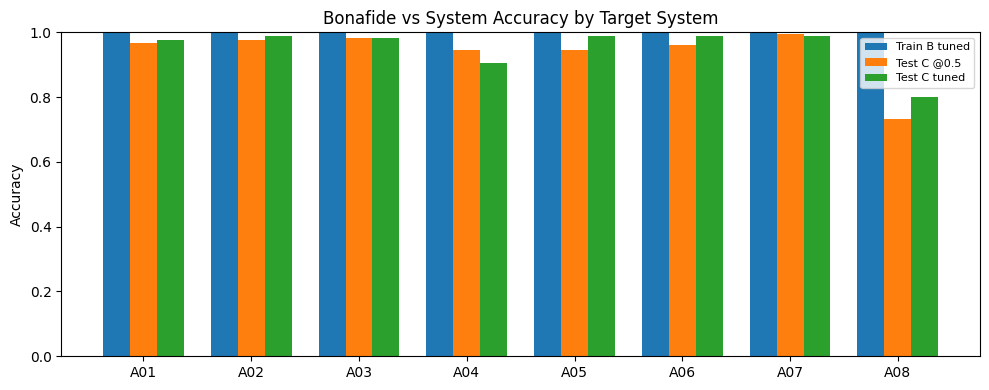

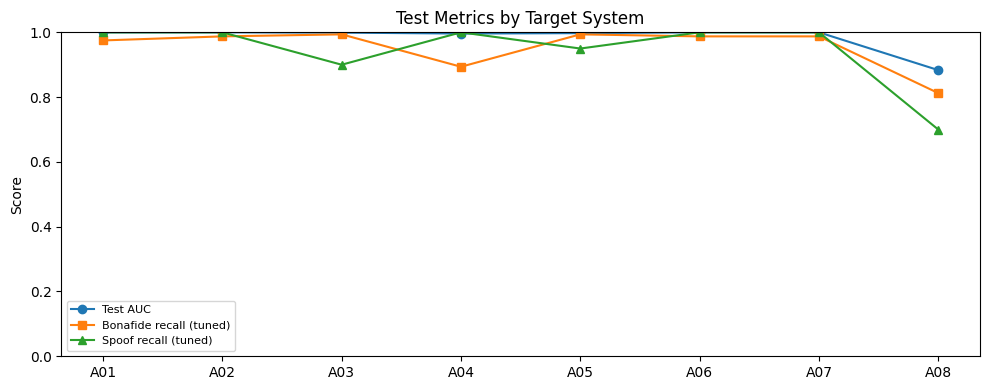

In [7]:
# Diagrams: train/test accuracy by system + test AUC by system
summary_df = pd.read_csv(OUT_DIR / 'all_systems_metrics_summary.csv')

x = np.arange(len(summary_df))
width = 0.25
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(x - width, summary_df['train_accuracy_tuned'], width, label='Train B tuned')
ax.bar(x, summary_df['test_accuracy_thr_0_5'], width, label='Test C @0.5')
ax.bar(x + width, summary_df['test_accuracy_tuned'], width, label='Test C tuned')
ax.set_xticks(x)
ax.set_xticklabels(summary_df['target_system'])
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('Bonafide vs System Accuracy by Target System')
ax.legend(fontsize=8)
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(summary_df['target_system'], summary_df['test_auc'], marker='o', label='Test AUC')
ax.plot(summary_df['target_system'], summary_df['test_bonafide_recall_tuned'], marker='s', label='Bonafide recall (tuned)')
ax.plot(summary_df['target_system'], summary_df['test_spoof_recall_tuned'], marker='^', label='Spoof recall (tuned)')
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Test Metrics by Target System')
ax.legend(fontsize=8)
plt.tight_layout(); plt.show()
